In [1]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import multiprocessing
from shapely.geometry import Point, LineString

data_dir = os.path.join("../../data/embeddings/")
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def evaluate_imd_model(y_true, y_pred, column, plot=True, plot_collectively = False, ax=False ):

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Scatter plot
    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)

        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}")
        ax.grid(True)

        # Annotate with R² and RMSE using axes coordinates (0–1)
        ax.text(0.01, 0.99,
            f'R² = {r2:.2f},  Spearman = {spearman_corr:.2f},\nRMSE = {rmse:.0f}, MAE = {mae:.0f}',
            transform=ax.transAxes,fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.show()

    # Scatter plot
    if plot_collectively:
        ax.scatter(y_true, y_pred, alpha=0.7)
        ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        ax.set_xlabel(f"True")
        ax.set_ylabel(f"Predicted")
        ax.set_title(f"{column}", fontsize=15)
        ax.grid(True)
        ax.text(
            0.01, 0.99,  # x=1% from left, y=99% from bottom
            f'R² = {r2:.2f}, RMSE = {rmse:.0f}, MAE = {mae:.0f}, Spearman = {Spearman_rank_corr:.2f}',
            transform=ax.transAxes,  # use axes coordinates
            fontsize=12,
            verticalalignment='top',  # anchor to top so it doesn’t go outside
            horizontalalignment='left')
    
    return metrics

Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


### Get imd data

In [2]:
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

# 1. Using mean embedding per LSOA

### Get data

In [96]:
mean_embeddings = pd.read_pickle(data_dir +"embedding_summaries/mean_embeddings_per_lsoa.pkl")
# mean_embeddings = mean_embeddings.merge(central_lsoas, on ='LSOA11CD')[['LSOA11CD', 'mean_embedding']]
mean_embeddings_with_imd = pd.merge(left=mean_embeddings, right=imd, on="LSOA21CD")
mean_embeddings_with_imd['imd_rerank'] = mean_embeddings_with_imd['imd_rank'].rank(method='first').astype(int)

### Build model

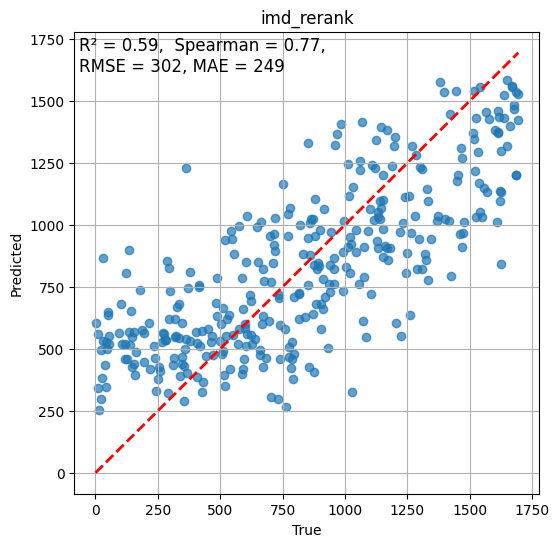

In [81]:
X = np.stack(mean_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = mean_embeddings_with_imd['imd_rerank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred, 'imd_rerank', plot=True, plot_collectively = False, ax=False)

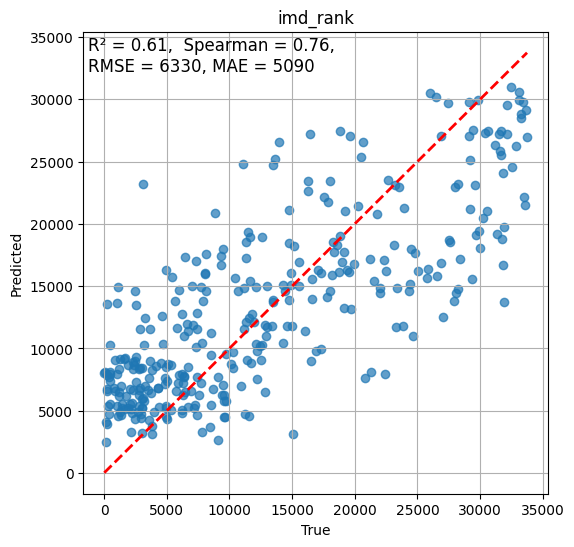

In [56]:
X = np.stack(mean_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = mean_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred, 'imd_rank', plot=True, plot_collectively = False, ax=False)

# 2. Using median embedding per LSOA

### Get data

In [82]:
median_embeddings = pd.read_pickle(data_dir +"embedding_summaries/median_embeddings_per_lsoa.pkl")
# median_embeddings = median_embeddings.merge(central_lsoas, on ='LSOA11CD')[['LSOA11CD', 'median_embedding']]
median_embeddings_with_imd = pd.merge(left=median_embeddings, right=imd, on="LSOA21CD")
median_embeddings_with_imd['imd_rerank'] = median_embeddings_with_imd['imd_rank'].rank(method='first').astype(int)

### Build model

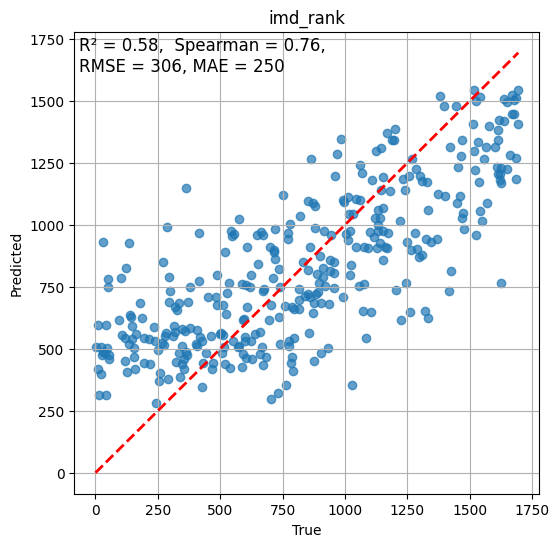

In [83]:
X = np.stack(median_embeddings_with_imd["median_embedding"].values)     # shape (n_points, embed_dim)
y = median_embeddings_with_imd['imd_rerank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred, 'imd_rank', plot=True, plot_collectively = False, ax=False)


# 3. Using max embedding per LSOA

### Get data

In [5]:
max_embeddings = pd.read_pickle(data_dir +"embedding_summaries/max_embeddings_per_lsoa.pkl")
# median_embeddings = median_embeddings.merge(central_lsoas, on ='LSOA11CD')[['LSOA11CD', 'median_embedding']]
max_embeddings_with_imd = pd.merge(left=max_embeddings, right=imd, on="LSOA21CD")
max_embeddings_with_imd['imd_rerank'] = max_embeddings_with_imd['imd_rank'].rank(method='first').astype(int)

### Build model

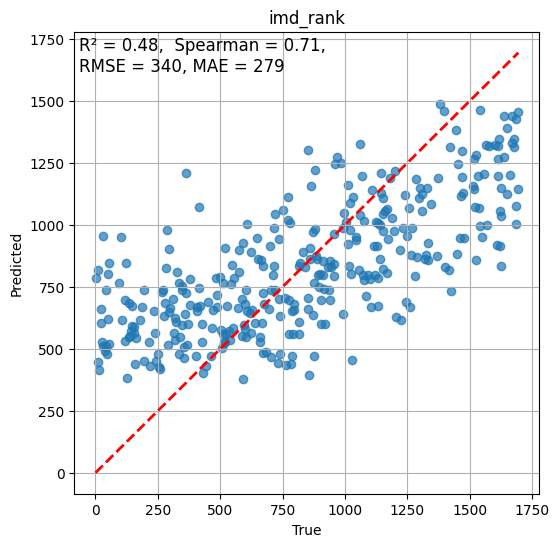

In [6]:
X = np.stack(max_embeddings_with_imd["max_embedding"].values)     # shape (n_points, embed_dim)
y = max_embeddings_with_imd['imd_rerank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred, 'imd_rank', plot=True, plot_collectively = False, ax=False)


# Fit model properly

In [ ]:
X = np.stack(median_embeddings_with_imd["median_embedding"].values)     # shape (n_points, embed_dim)
y = median_embeddings_with_imd['imd_rerank'].values

In [93]:
X = np.stack(median_embeddings_with_imd["median_embedding"].values)     # shape (n_points, embed_dim)
y = median_embeddings_with_imd['imd_rerank'].values

# -------------------------
# Split data into training and test sets
# -------------------------
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42
)
print(f"Training points: {X_train.shape[0]}, Test points: {X_test.shape[0]}")

# -------------------------
# Define model pipelines and parameter grids
# -------------------------
models = []
param_grids = []

# 1. Linear Regression
pipe_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
models.append(pipe_linear)
param_grids.append({})

# 2. Random Forest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(random_state=42))
])
models.append(pipe_rf)
param_grids.append({
    'reg__n_estimators': [100, 200],
    'reg__max_depth': [None, 10, 20]})

# 4. XGBoost Regressor
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),  # scaling not strictly necessary but fine to keep
    ('reg', XGBRegressor(
        objective='reg:squarederror',  # standard regression objective
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])
models.append(pipe_xgb)
param_grids.append({
    'reg__n_estimators': [100, 300],
    'reg__max_depth': [3, 6, 10],
    'reg__learning_rate': [0.01, 0.1, 0.3],
    'reg__subsample': [0.8, 1.0]
})

# 3. Neural Network (MLPRegressor)
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', MLPRegressor(max_iter=1500,
                             activation='relu',           # default, works well for embeddings
    solver='adam',               # stochastic gradient optimizer
    learning_rate_init=1e-3,     # small learning rate improves convergence on high-dim data
    early_stopping=True,         # stop automatically if validation score doesn’t improve
    n_iter_no_change=50,         # patience for early stopping
    random_state=42,
    verbose=False))
])
models.append(pipe_mlp)
param_grids.append({
    'reg__hidden_layer_sizes': [(100,), (100, 50)],
    'reg__alpha': [1e-4, 1e-3]
})


# -------------------------
# Perform cross-validation
# -------------------------
best_model = None
best_score = -np.inf
best_model_name = None
best_params = {}

print("Training models")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ncores = min(multiprocessing.cpu_count() - 1, 100)
print(f"Using {ncores} cores.")

for model, param_grid, name in zip(
    models, param_grids, ["LinearReg", "RandomForest", "XGBoost", "NeuralNet"]
):
    print(f"\nTraining: {name}...")
    if param_grid:
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='r2', n_jobs=ncores)
        grid.fit(X_train, y_train)
        cv_score = grid.best_score_
        model_best = grid.best_estimator_
        params_best = grid.best_params_
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
        cv_score = np.mean(scores)
        model.fit(X_train, y_train)
        model_best = model
        params_best = {}

    print(f"{name} CV mean R² = {cv_score:.3f} {('(best params: '+str(params_best)+')') if params_best else ''}")

    # Track the best
    if cv_score > best_score:
        best_score = cv_score
        best_model = model_best
        best_model_name = name
        best_params = params_best.copy()

print(f"\nBest model: {best_model_name} (R² = {best_score:.3f})")
print(f"Best hyperparameters: {best_params}")

print(f"Best model from CV: {best_model_name} with R^2 = {best_score:.3f} and params {best_params}")

# Save the meta-data so the model can be trained on the different domains of deprivation
best_model_info = {
    "model_name": best_model_name,
    "best_score": float(best_score),
    "best_params": best_params
}

## ---- SAVE the model ----
#bundle = {
#    "model": best_model,                 # the fitted Pipeline
#    "name": best_model_name,             # e.g., "RandomForest"
#    "cv_score_r2": float(best_score),    # ensure JSON-safe
#    "trained_at": datetime.utcnow().isoformat() + "Z",
#    "sklearn_version": sklearn.__version__
#}
#dump(bundle, os.path.join(data_dir, "5-imd_best_model_bundle.joblib", compress=3)
#print("Saved to best_model_bundle.joblib")



Training points: 1356, Test points: 339
Training models
Using 31 cores.

Training: LinearReg...
LinearReg CV mean R² = -0.064 

Training: RandomForest...
RandomForest CV mean R² = 0.543 (best params: {'reg__max_depth': None, 'reg__n_estimators': 200})

Training: XGBoost...


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGB

XGBoost CV mean R² = 0.593 (best params: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 1.0})

Training: NeuralNet...
NeuralNet CV mean R² = 0.529 (best params: {'reg__alpha': 0.001, 'reg__hidden_layer_sizes': (100, 50)})

Best model: XGBoost (R² = 0.593)
Best hyperparameters: {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 1.0}
Best model from CV: XGBoost with R^2 = 0.593 and params {'reg__learning_rate': 0.1, 'reg__max_depth': 3, 'reg__n_estimators': 300, 'reg__subsample': 1.0}
Iteration 385, loss = 7214.15766629
Validation score: 0.544218
Iteration 386, loss = 7154.72802331
Validation score: 0.544347
Iteration 387, loss = 7109.10405854
Validation score: 0.544462
Iteration 388, loss = 7051.78086471
Validation score: 0.544764
Iteration 389, loss = 6992.57644488
Validation score: 0.544663
Iteration 390, loss = 6940.07206040
Validation score: 0.544215
Iteration 391, loss = 6895.37274084
Validation

Iteration 130, loss = 11682.94868305
Validation score: 0.544657
Iteration 131, loss = 11449.53985367
Validation score: 0.545224
Iteration 132, loss = 11214.58234642
Validation score: 0.543038
Iteration 133, loss = 10997.85997300
Validation score: 0.541229
Iteration 134, loss = 10773.65792360
Validation score: 0.542864
Iteration 135, loss = 10547.53310251
Validation score: 0.541453
Iteration 136, loss = 10328.77475764
Validation score: 0.540229
Iteration 137, loss = 10130.27514672
Validation score: 0.540265
Iteration 138, loss = 9937.44331457
Validation score: 0.542827
Iteration 139, loss = 9725.96273498
Validation score: 0.541609
Iteration 140, loss = 9508.60213203
Validation score: 0.540597
Iteration 141, loss = 9349.03043092
Validation score: 0.537732
Iteration 142, loss = 9131.41866563
Validation score: 0.540013
Iteration 143, loss = 8935.30895070
Validation score: 0.540722
Iteration 144, loss = 8762.46436513
Validation score: 0.540347
Iteration 145, loss = 8553.25412955
Validation 

In [ ]:
import json

with open(os.path.join(data_dir, "5-imd_best_model_info.json"), "w") as f:
    json.dump(best_model_info, f, indent=2)
print(f"Cached model info:", best_model_info)